In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import scipy.io.wavfile as wav
import os
from sklearn.metrics import accuracy_score
import time
import torchaudio
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [5]:
root = "/kaggle/input/audio-mnist/data"
data = []
target = []
person = []

for i in range(1, 61):
    folderPath = os.path.join(root,str(i).zfill(2))
    files = os.listdir(folderPath)
    for file in files:
        tempPerson = ''
        temp = librosa.load(folderPath + '/' + file)
        temp = temp[0]
        target += file[0]
        person.append(int(i))
        data.append(temp)

In [6]:
pd.DataFrame(target).value_counts()

0    3000
1    3000
2    3000
3    3000
4    3000
5    3000
6    3000
7    3000
8    3000
9    3000
Name: count, dtype: int64

In [7]:
class_names=sorted(pd.DataFrame(target)[0].unique().tolist())

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

paddedDataa = pad_sequences(data, padding='post', dtype='float32')

In [9]:
paddedDataa.shape

(30000, 22050)

In [10]:
target = [int(item) for item in target]

In [12]:
import torch
from torch.utils.data import Dataset
import scipy.io.wavfile as wav
import librosa
from torch.nn.functional import pad
from tensorflow.keras.preprocessing.sequence import pad_sequences


class AudioMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.ToSpectrogram = torchaudio.transforms.MelSpectrogram()
        self.ToDB = torchaudio.transforms.AmplitudeToDB()
        paddedDataa = pad_sequences(X, padding='post', dtype='float32')
        self.audio = paddedDataa
        self.labels = y
        assert(len(self.audio) == len(self.labels))
    
    def __len__(self):
        return len(self.audio)
    
    def padding(self, file):
        audio_padded = torch.zeros((1,25500))
        audio_padded[0,:len(file)] = torch.Tensor(file)
        return audio_padded
    
    def mfcc_data(self, file):
        spectrogram = self.ToSpectrogram(file)
        spectrogram = self.ToDB(spectrogram)
        return spectrogram[0]
    
    def __getitem__(self, idx):
        padded = self.padding(self.audio[idx])
        audio_seq = self.mfcc_data(padded)
        normalized_data = (audio_seq - (-100)) / (20 - (-100))
        normalized_data = torch.FloatTensor(normalized_data)
        label = self.labels[idx]
        return normalized_data.flatten(), label

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(paddedDataa, target, test_size=0.15, random_state=42)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(AudioMNISTDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(AudioMNISTDataset(X_test, y_test), batch_size=32)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [16]:
class VoiceMNISTTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_heads, num_layers):
        super(VoiceMNISTTransformer, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.Transformer(d_model=hidden_dim,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers,
                                          nhead=num_heads,
                                          batch_first=True).encoder
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.bn = nn.LazyBatchNorm1d()

    def forward(self, x):
        x = self.bn(self.embedding(x)).relu()
        output = self.transformer(x)
        output = self.fc(output)
        return output

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [41]:
input_dim = 16384
hidden_dim = 512
num_classes = 10
num_heads = 8
num_layers = 4
num_epochs = 10
model = VoiceMNISTTransformer(input_dim, hidden_dim, num_classes, num_heads, num_layers).to(device)
start_time = time.time()
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
train_correct=[]
best_model = None
best_model_loss = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
counter = 0
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    trn_corr = 0
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X_train.to(device))
        loss = criterion(y_pred, y_train.to(device))
        loss.backward()
        optimizer.step()
        counter += 1
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.to(device)).sum()
        trn_corr += batch_corr

        if batch_idx % 200 == 0:
            print(f"Training Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.6f}")

    loss = loss.detach().cpu().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)

    model.eval()
    tst_corr = 0
    all_true = []
    all_pred = []

    with torch.no_grad():
        for batch_idx, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_val = model(X_test)
            loss = criterion(y_val, y_test)

            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr

            all_true.extend(y_test.cpu().numpy())
            all_pred.extend(predicted.cpu().numpy())

    test_loss = loss.item()
    test_acc = tst_corr.item() * 100 / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    # Compute and print F1 score, accuracy, precision, and recall
    f1 = f1_score(all_true, all_pred, average='weighted')
    acc = accuracy_score(all_true, all_pred)
    precision = precision_score(all_true, all_pred, average='weighted')
    recall = recall_score(all_true, all_pred, average='weighted')

    print(f"\nValidation/Test Loss: {test_loss:.6f}, Accuracy: {test_acc:.2f}%")
    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '



Epoch 1/10
Training Batch 0/797 Loss: 2.407933
Training Batch 200/797 Loss: 0.384730
Training Batch 400/797 Loss: 0.315218
Training Batch 600/797 Loss: 0.197178

Validation/Test Loss: 0.034248, Accuracy: 98.24%
F1 Score: 0.9825, Precision: 0.9826, Recall: 0.9824

Epoch 2/10
Training Batch 0/797 Loss: 0.072769
Training Batch 200/797 Loss: 0.066925
Training Batch 400/797 Loss: 0.085471
Training Batch 600/797 Loss: 0.036062

Validation/Test Loss: 0.012257, Accuracy: 99.04%
F1 Score: 0.9904, Precision: 0.9905, Recall: 0.9904

Epoch 3/10
Training Batch 0/797 Loss: 0.119527
Training Batch 200/797 Loss: 0.136907
Training Batch 400/797 Loss: 0.053247
Training Batch 600/797 Loss: 0.038226

Validation/Test Loss: 0.012331, Accuracy: 99.31%
F1 Score: 0.9931, Precision: 0.9932, Recall: 0.9931

Epoch 4/10
Training Batch 0/797 Loss: 0.044713
Training Batch 200/797 Loss: 0.011052
Training Batch 400/797 Loss: 0.030312
Training Batch 600/797 Loss: 0.079212

Validation/Test Loss: 0.019850, Accuracy: 98.

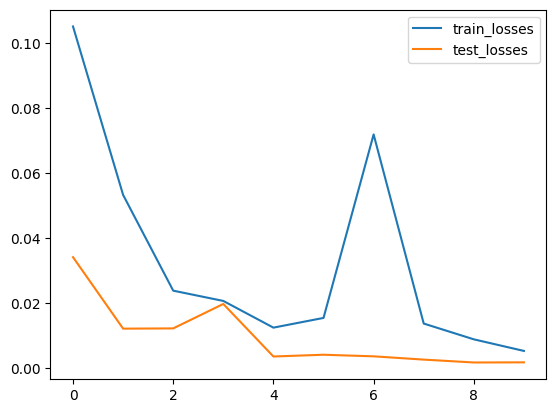

In [43]:
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()
plt.show()

In [42]:
model.eval()

y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(y_pred[0:5])

[7, 2, 8, 4, 6]


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

           0     0.9956    0.9956    0.9956       457
           1     0.9978    0.9978    0.9978       456
           2     1.0000    0.9979    0.9989       470
           3     0.9931    0.9931    0.9931       434
           4     0.9978    0.9956    0.9967       453
           5     0.9956    1.0000    0.9978       457
           6     1.0000    0.9977    0.9989       442
           7     0.9910    1.0000    0.9955       441
           8     1.0000    0.9977    0.9989       438
           9     1.0000    0.9956    0.9978       452

    accuracy                         0.9971      4500
   macro avg     0.9971    0.9971    0.9971      4500
weighted avg     0.9971    0.9971    0.9971      4500



In [46]:
torch.save(model.state_dict(), 'transformer.pt')